# Group 13 - Yelp Review Analysis for Module 3 
Group members:
- Jonquil Liao
- Yuhan Zhou
- Yike Wang

In [1]:
# import initial modules
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# Preparation and trial

In [2]:
# read in reviews from previous notebook
data = pd.read_csv('review_steakhouse.csv')

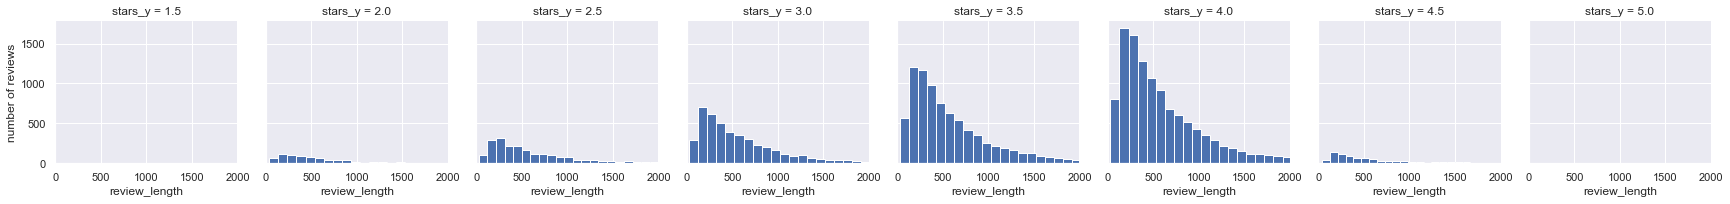

In [5]:
import seaborn as sns
sns.set()
data['review_length'] = data.text.map(len)
ax = sns.FacetGrid(data=data, col='stars_y',xlim=(0, 2000)).map(plt.hist, 'review_length', bins=50)
ax.axes[0][0].set(ylabel='number of reviews');

In [6]:
data['review_length'] = data.text.map(len)

In [7]:
import numpy as np
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re, string
import sys
import time
import collections
from array import array

In [8]:
badreviews = data[(data.stars_y <= 3 )]
goodreviews = data[(data.stars_y > 3)]
badreviews = badreviews.text
goodreviews = goodreviews.text
print('Postive Reviews:  {:,}'.format(len(goodreviews)))
print('Negative Reviews:  {:,}'.format(len(badreviews)))

Postive Reviews:  20,948
Negative Reviews:  7,461


In [9]:
badreviews = ["".join([char for char in a if char not in string.punctuation]) for a in badreviews]
goodreviews = ["".join([char for char in a if char not in string.punctuation]) for a in goodreviews]

In [10]:
# additional stopwords
from sklearn.feature_extraction import text 
extra_words = ['ve', 'like', 'got', 'just', 'us','great',
               'good','best','nice','always','back','ever',
               'ive','go','well','not','bad','terrible',
               'don', 'really', 'said', 'told', 'ok','dont',
               'came', 'went', 'did', 'didn','one','would']
stop_words = text.ENGLISH_STOP_WORDS.union(extra_words)

In [11]:
text1=badreviews
text1 = [a.lower() for a in text1]
words1 = [nltk.word_tokenize(a) for a in text1]
filtered_words1 = [[word for word in a if word not in stop_words] for a in words1]
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

In [12]:
text2=goodreviews
text2 = [a.lower() for a in text2]
words2 = [nltk.word_tokenize(a) for a in text2]
filtered_words2 = [[word for word in a if word not in stop_words] for a in words2]

In [13]:
lemmatized_words1 = [[lmtzr.lemmatize(x) for x in a] for a in filtered_words1]
lemmatized_words2 = [[lmtzr.lemmatize(x) for x in a] for a in filtered_words2]

In [14]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
lemmatized_words1=[ ' '.join(map(str, sent)) for sent in lemmatized_words1]
lemmatized_words2=[ ' '.join(map(str, sent)) for sent in lemmatized_words2]

In [15]:
tfidf_model1 = TfidfVectorizer(stop_words=stop_words,
                        ngram_range=(1,1))
tfidf_model2 = TfidfVectorizer(stop_words=stop_words, 
                        ngram_range=(1,1))
result1=tfidf_model1.fit_transform(lemmatized_words1)
result2=tfidf_model2.fit_transform(lemmatized_words2)

In [16]:
bad_df = pd.DataFrame(result1.todense(), columns=[tfidf_model1.get_feature_names()])
good_df = pd.DataFrame(result2.todense(), columns=[tfidf_model2.get_feature_names()])
col_means_bad = {}
for col in bad_df:
    col_means_bad[col] = bad_df[col].mean()

col_means_good = {}
for col in good_df:
    col_means_good[col] = good_df[col].mean()
    
top_words = 8

print('Top words in good reviews:')
print(sorted(col_means_good, key=col_means_good.get, reverse=True)[:top_words])

print('Top words in bad reviews:')
print(sorted(col_means_bad, key=col_means_bad.get, reverse=True)[:top_words])

Top words in good reviews:
[('food',), ('steak',), ('service',), ('place',), ('time',), ('restaurant',), ('bar',), ('dinner',)]
Top words in bad reviews:
[('food',), ('service',), ('steak',), ('place',), ('time',), ('restaurant',), ('drink',), ('ordered',)]


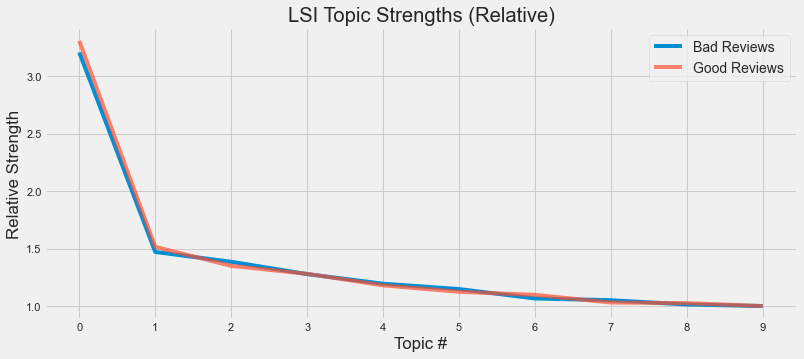

In [17]:
'This part credited to Ankur Vishwakarma, Oakland, CA. https://github.com/Vishwacorp/'
from gensim import corpora, models, similarities, matutils
corpus1 = matutils.Sparse2Corpus(result1.transpose())
corpus2 = matutils.Sparse2Corpus(result2.transpose())
word_bad = dict((v,k) for k,v in tfidf_model1.vocabulary_.items())
word_good = dict((v,k) for k,v in tfidf_model2.vocabulary_.items())
word_bad2 = corpora.Dictionary.from_corpus(corpus1, id2word=word_bad)
word_good2 = corpora.Dictionary.from_corpus(corpus2, id2word=word_good)
lsi_bad = models.LsiModel(corpus1, id2word=word_bad2, num_topics=10)
lsi_good = models.LsiModel(corpus2, id2word=word_good2, num_topics=10)

singular_values_bad = lsi_bad.projection.s.tolist()
singular_values_bad_rel = [sv/singular_values_bad[-1] for sv in singular_values_bad]
singular_values_good = lsi_good.projection.s.tolist()
singular_values_good_rel = [sv/singular_values_good[-1] for sv in singular_values_good]
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,5))
plt.plot(range(len(singular_values_bad)), singular_values_bad_rel, label='Bad Reviews', alpha=1.0)
plt.plot(range(len(singular_values_good)), singular_values_good_rel, label='Good Reviews', alpha=0.7)
plt.xticks(range(len(singular_values_bad)), range(len(singular_values_bad)))
plt.xlabel('Topic #')
plt.ylabel('Relative Strength')
plt.title('LSI Topic Strengths (Relative)')
plt.legend(loc=0, fontsize='medium');

In [18]:
import pprint
from pprint import pprint

In [19]:
no_top_words = 8

print('Top %d words in POSITIVE reviews:' %no_top_words, end='')
print(sorted(col_means_good, key=col_means_good.get, reverse=True)[:no_top_words])

print('Top %d words in NEGATIVE reviews:' %no_top_words, end='')
print(sorted(col_means_bad, key=col_means_bad.get, reverse=True)[:no_top_words])

Top 8 words in POSITIVE reviews:[('food',), ('steak',), ('service',), ('place',), ('time',), ('restaurant',), ('bar',), ('dinner',)]
Top 8 words in NEGATIVE reviews:[('food',), ('service',), ('steak',), ('place',), ('time',), ('restaurant',), ('drink',), ('ordered',)]


### Trial with NMF <a name='s4'></a>

In [20]:
%%time
# negative values in LSA topics are annoying
# let's see if we can fix that with NMF
from sklearn.decomposition import NMF

# change num_topics
num_topics = 4

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(result2)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(result1)
H_neg = nmf_neg.components_

C:\Users\13754\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Wall time: 2.5 s


In [27]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

no_topics = num_topics
no_top_words = 6

print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_model2.get_feature_names(), no_topics, no_top_words)

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_model1.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   1.005*table, 0.807*meat, 0.785*time, 0.771*bar, 0.652*salad, 0.604*restaurant
Topic 1:   1.511*cheese, 1.287*curd, 1.251*burger, 0.907*old, 0.842*beer, 0.782*fashioned
Topic 2:   1.701*food, 1.271*service, 0.858*place, 0.714*excellent, 0.709*amazing, 0.704*atmosphere
Topic 3:   2.608*steak, 0.798*cooked, 0.628*medium, 0.527*rare, 0.488*filet, 0.485*ordered

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   1.080*minute, 0.837*table, 0.763*order, 0.615*took, 0.611*time, 0.601*drink
Topic 1:   1.429*steak, 0.709*salad, 0.564*ordered, 0.508*cooked, 0.498*potato, 0.383*medium
Topic 2:   1.207*food, 0.911*place, 0.848*service, 0.458*bar, 0.424*price, 0.423*time
Topic 3:   2.276*wing, 0.494*sauce, 0.303*quaker, 0.290*buffet, 0.270*chicken, 0.255*beer


As expected, these topics are far more interpretable.  
* First two topics for positive reviews seem to be (1) salad and sides and (2) meals other than steak.
* First two topics for negative reviews seem to be (1) slow service and (2) temperature of steak (seems like thai food in this subset of data).

In [39]:
np.random.seed(3)
num_reviews = 18000
random_pos = np.random.choice(goodreviews, size=num_reviews)

In [40]:
np.random.seed(30)
num_reviews = 5000
random_neg = np.random.choice(badreviews, size=num_reviews)

### Review Similarity in NMF space <a name='s5'></a>

In [41]:
# look at a random positive review
review_num = np.random.randint(0, high=len(random_pos))
print(review_num)
print(random_pos[review_num])

16675
Love it here Scallops and Sea Bass are delicious Its comfortable a little pricey but worth the meal


In [42]:
# compute cosine similarities of this review with all other reviews in the new space
import sklearn.metrics.pairwise as smp

cosines = {}
for ind, review in enumerate(W_pos):
    similarity = smp.cosine_similarity(W_pos[review_num].reshape(1,-1), review.reshape(1,-1))
    cosines[ind] = similarity[0][0]

In [43]:
# get top 3 matching reviews
for n in sorted(cosines, key=cosines.get, reverse=True)[1:4]:
    print('-'*50)
    print('>> Similarity {:.3f}'.format(cosines[n]))
    print(random_pos[n])
print('-'*50)

--------------------------------------------------
>> Similarity 1.000
Disclaimer I am a HUGE oyster fan and came into this restaurant with high expectations  I wasnt disappointed

First things first Oyster Shots  We tried the Willapa oyster shots which were their version of bloody mary shots  The bartender fished out huge oysters for us and plopped them in the bottom of the glasses  Absolutely delicious  The shots were a bit large and took a few gulps to finish but were so delicious I wasnt upset They had a variety of other oyster shots that we didnt trybut am looking forward to in the future

Another thing not to miss are their specialty cocktails  We came about an hour early just to have a drink at the bar and check out the new decor  A pleasant and welcoming change compared to the set up when it was Magnus  Everything is bright and welcoming but very romantic if you want to just have drinks before dinner  Do not miss their specialty cocktail menu  I am usually not a fan of any spec

NMF seems to be working well and making good topics for us. But just to give it a shot, let's use CountVectorizer (instead of TFIDF) and try topic modeling through LDA. While slower, its use of a dirichlet prior can often give good results.

### Trial with Count Vectorizer <a name='s6'></a>

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a vectorizer object to generate term document counts
cv_pos = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

cv_neg = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 5000
cv_random_neg = np.random.choice(badreviews, size=num_reviews)
cv_random_pos = np.random.choice(goodreviews, size=num_reviews)

# Get the cv vectors
cv_neg_vectors = cv_neg.fit_transform(cv_random_neg).transpose()
cv_pos_vectors = cv_pos.fit_transform(cv_random_pos).transpose()

In [45]:
# Convert sparse matrix of counts to a gensim corpus
corpus_neg = matutils.Sparse2Corpus(cv_neg_vectors)
corpus_pos = matutils.Sparse2Corpus(cv_pos_vectors)

# save a mapping (dict) of row id to word (token) for later use by gensim 
id2word_cv_pos = dict((v, k) for k, v in cv_pos.vocabulary_.items())
id2word_cv_neg = dict((v, k) for k, v in cv_neg.vocabulary_.items())

### LDA(Count Vectorizer)<a name='s7'></a>

In [46]:
%%time
# create lda multicore model
lda_pos = models.ldamulticore.LdaMulticore(corpus=corpus_pos, num_topics=4, 
                                           id2word=id2word_cv_pos, passes=10, workers=15)
lda_neg = models.ldamulticore.LdaMulticore(corpus=corpus_neg, num_topics=4, 
                                           id2word=id2word_cv_neg, passes=10, workers=15)

Wall time: 53.8 s


In [47]:
print('Top topics + words for POSITIVE reviews')
print('-'*39)
pprint(lda_pos.print_topics(num_words=7))

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
pprint(lda_neg.print_topics(num_words=7))

Top topics + words for POSITIVE reviews
---------------------------------------
[(0,
  '0.016*"food" + 0.013*"service" + 0.012*"steak" + 0.009*"delicious" + '
  '0.009*"amazing" + 0.008*"time" + 0.007*"menu"'),
 (1,
  '0.013*"steak" + 0.011*"ordered" + 0.010*"salad" + 0.009*"meat" + '
  '0.008*"restaurant" + 0.008*"time" + 0.008*"food"'),
 (2,
  '0.030*"food" + 0.021*"place" + 0.020*"service" + 0.013*"bar" + '
  '0.008*"restaurant" + 0.007*"steak" + 0.007*"dinner"'),
 (3,
  '0.014*"cheese" + 0.011*"place" + 0.009*"ordered" + 0.008*"food" + '
  '0.008*"curds" + 0.007*"time" + 0.007*"old"')]

Top topics + words for NEGATIVE reviews
---------------------------------------
[(0,
  '0.013*"wings" + 0.010*"bar" + 0.010*"place" + 0.009*"service" + '
  '0.009*"happy" + 0.008*"menu" + 0.008*"hour"'),
 (1,
  '0.021*"steak" + 0.017*"ordered" + 0.013*"salad" + 0.009*"place" + '
  '0.008*"cooked" + 0.008*"service" + 0.007*"cheese"'),
 (2,
  '0.014*"time" + 0.013*"service" + 0.013*"minutes" + 0.011*"

It can be seen that, topics are mixed up for the positive reviews.So we would still use TFIDF to do the modeling.

### Continuing with NMF Topics <a name='s8'></a>

In [48]:
%%time
# let's remind ourselves of the POSITIVE topics
print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos,tfidf_model2.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   1.005*table, 0.807*meat, 0.785*time, 0.771*bar, 0.652*salad, 0.604*restaurant
Topic 1:   1.511*cheese, 1.287*curd, 1.251*burger, 0.907*old, 0.842*beer, 0.782*fashioned
Topic 2:   1.701*food, 1.271*service, 0.858*place, 0.714*excellent, 0.709*amazing, 0.704*atmosphere
Topic 3:   2.608*steak, 0.798*cooked, 0.628*medium, 0.527*rare, 0.488*filet, 0.485*ordered
Wall time: 23.5 ms


In [49]:
# we can investigate a random positive review and see how it's distributed across those topics
review_num = np.random.randint(0, high=len(random_pos))
print('Positive Review #%d' %review_num)
print('-'*25)
print(random_pos[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_pos[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Positive Review #12920
-------------------------
This a great restaurant that never disappoints and certainly is one of the east sides legendary dining locations The perfect place for a quality meal fine wine and wonderful service and a pleasure walk before or after

I Highly recommend this establishment
-------------------------
Topic 0: 0.0176
Topic 3: 0.0140
Topic 1: 0.0095
Topic 2: 0.0000


In [50]:
print('Top topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_model1.get_feature_names(), no_topics, no_top_words)

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   1.080*minute, 0.837*table, 0.763*order, 0.615*took, 0.611*time, 0.601*drink
Topic 1:   1.429*steak, 0.709*salad, 0.564*ordered, 0.508*cooked, 0.498*potato, 0.383*medium
Topic 2:   1.207*food, 0.911*place, 0.848*service, 0.458*bar, 0.424*price, 0.423*time
Topic 3:   2.276*wing, 0.494*sauce, 0.303*quaker, 0.290*buffet, 0.270*chicken, 0.255*beer


In [51]:
len(random_neg)

5000

In [52]:
# now investigate a random negative review and see how it's distributed across those topics
review_num = np.random.randint(0, high=len(random_neg))
print('Negative Review #%d' %review_num)
print('-'*25)
print(random_neg[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_neg[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Negative Review #746
-------------------------
So where do I startmy ever pressing girlfriend picked this spot for our nye excursion The menu looked pretty nice online and even had a few more options when we got there We were quickly seated even without a reservation but unfortunately this is the end of the highlight 

The menus were changed for nye and the options were very limited Everything was about 15 more expensive and the things I wanted were off the menu The jalapeño crab dip was exceptional and I wish that is all I ordered 

Our server was ok and wasnt that talkative at all I had the stuffed shrimp which ended up being just shrimp with crab on top I had a side of the roasted potatoes They were only 4yeah and they were cold and barely seasoned 

overall it could be a very good restaurant but the portions are very small compared to the price The experience did not match the price either If you come back get the jalapeño dip and leave 

The drink menu was very limited also Not a 

# Topic Modeling All Reviews <a name='s9'></a>  

In [53]:
print('Postive Reviews:  {:,}'.format(len(goodreviews)))
print('Negative Reviews:  {:,}'.format(len(badreviews)))

Postive Reviews:  20,948
Negative Reviews:  7,461


In [58]:
%%time
# Create a vectorizer object to generate term document counts
tfidf_model1 = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_model2 = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get the vectors
neg_vectors = tfidf_model1.fit_transform(badreviews)
pos_vectors = tfidf_model2.fit_transform(goodreviews)

Wall time: 1.52 s


In [59]:
%%time
# NMF for all reviews
from sklearn.decomposition import NMF

# change num_topics
num_topics = 4

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

Wall time: 1.15 s


In [60]:
no_topics = num_topics
no_top_words = 6

print('Topics for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_model2.get_feature_names(), no_topics, no_top_words)

print('\nTopics for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_model1.get_feature_names(), no_topics, no_top_words)

Topics for POSITIVE reviews
---------------------------------------
Topic 0:   2.060*steak, 0.877*cooked, 0.739*ordered, 0.658*salad, 0.648*medium, 0.608*filet
Topic 1:   1.628*cheese, 1.353*curds, 0.996*old, 0.860*fashioned, 0.822*burger, 0.689*beer
Topic 2:   1.673*food, 1.299*service, 0.800*place, 0.747*excellent, 0.746*amazing, 0.732*atmosphere
Topic 3:   0.773*bar, 0.752*table, 0.659*time, 0.479*minutes, 0.463*restaurant, 0.452*didnt

Topics for NEGATIVE reviews
---------------------------------------
Topic 0:   1.665*steak, 0.796*salad, 0.731*ordered, 0.641*cooked, 0.509*medium, 0.455*cheese
Topic 1:   0.884*minutes, 0.582*table, 0.552*order, 0.544*took, 0.530*waitress, 0.512*time
Topic 2:   1.010*place, 0.701*service, 0.599*bar, 0.379*friendly, 0.367*staff, 0.357*menu
Topic 3:   2.204*wings, 0.369*sauce, 0.357*chicken, 0.330*quaker, 0.314*wing, 0.294*buffet


In [87]:
# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'Quality of steaks and sides', 1:'Other main dishes', 
              2:'Service and atmosphere', 3:'Waiting time and table availbility'}

neg_topics = {0:'Steaks and salads', 1:"Waiting time and watiress response' response" , 2:'Service--attitude', 
              3:'Quality of other sides and snacks'}

### Adding Topic Weights to Pandas DataFrame <a name='s10'></a>

In [69]:
# we create dataframes for positive & negative reviews that we can
# later add topic information to
df_pos = data[['business_id', 'stars_y', 'text', 'review_length']][data.stars_y>3].reset_index()
df_neg = data[['business_id', 'stars_y', 'text', 'review_length']][data.stars_y<=3].reset_index()
df_pos.drop(labels='index', axis=1, inplace=True)
df_neg.drop(labels='index', axis=1, inplace=True)

In [70]:
print('Topic weights : ', W_pos[0])
print('Sum of weights: ', W_pos[0].sum())

Topic weights :  [0.00079404 0.02052135 0.04864945 0.0179198 ]
Sum of weights:  0.08788463592303748


Results like these are not easy to interpretate, Therefore, we can normalize the weights so they all add up to 1. Such scale is much more straightforward.

In [71]:
from sklearn.preprocessing import normalize
print('Normalized Topic weights : ', normalize(W_pos[0].reshape(1,-1), norm='l1'))
print('Sum of normalized weights: ', normalize(W_pos[0].reshape(1,-1), norm='l1').sum())

Normalized Topic weights :  [[0.00903497 0.2335033  0.55356031 0.20390141]]
Sum of normalized weights:  1.0


In [72]:
# add normalized topic weights to each review
df_pos = pd.concat([df_pos, pd.DataFrame(normalize(W_pos, norm='l1'))], axis=1)
df_neg = pd.concat([df_neg, pd.DataFrame(normalize(W_neg, norm='l1'))], axis=1)

In [73]:
# peek into a dataframe to ensure it worked right
df_neg.head()

,business_id,stars_y,text,review_length,0,1,2,3
0,lpxj6LFir23Ds6swW8a6fg,3.0,Very fresh food and authentic Italian taste. T...,259,0.182854,0.000000,0.702967,0.11418
1,zLnmmB9jiKg-A2Lggs64-A,3.0,"Not worth the price. Service was OK... ""Poop e...",64,0.000000,0.000000,1.000000,0.00000
2,qELIf4gzE_vlteu7pO7TZg,3.0,"Fantastic food and atmosphere, and right in th...",162,0.000000,0.071388,0.928612,0.00000
3,7ddnq3YQSKguGK15etqGLQ,3.0,We decided on short notice to try the new Ditk...,942,0.537401,0.000000,0.462599,0.00000
4,lpxj6LFir23Ds6swW8a6fg,3.0,The outdoor views from the deck are unparallel...,347,0.000000,0.261984,0.738016,0.00000


Here are the topic weights for each review in this dataframe. Next, we can group by the business_id and get mean topic weights per restaurant.

In [74]:
# group by business_id and apply mean/count functions to columns
df_pos_bsns = df_pos.groupby('business_id').agg({'stars_y':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean'}).reset_index()
df_neg_bsns = df_neg.groupby('business_id').agg({'stars_y':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean'}).reset_index()

In [75]:
df_pos_bsns.head(5)

,business_id,stars_y,text,review_length,0,1,2,3
0,-RQCdTsH5rkG702auLcEqA,3.5,35,697.057143,0.265975,0.085147,0.235490,0.413388
1,-bHpvkmiFzm_swHLYsGiqw,4.0,120,579.450000,0.190667,0.071186,0.413659,0.324488
2,0gbi6kYiAOnFwfZ_2_dXSA,4.0,117,634.709402,0.350508,0.060084,0.284954,0.304453
3,0grgvnq4GgoY-estWytUhg,3.5,103,755.203883,0.148926,0.080779,0.372326,0.397969
4,1njD5p7-FvV8uoHzwiVYCA,3.5,42,531.333333,0.332267,0.042691,0.232604,0.392438


In [76]:
df_neg_bsns.head()

,business_id,stars_y,text,review_length,0,1,2,3
0,0YA3RpY5KXcezPXcjdfOGQ,2.0,6,454.166667,0.413895,0.234186,0.351919,0.000000
1,0wUBRqU95D8URo5Ws4r5Qg,2.0,47,370.914894,0.170086,0.469782,0.289903,0.070229
2,1HtxtLaFgTeerAuF9Q5jRQ,3.0,23,699.826087,0.372505,0.294543,0.299048,0.033903
3,3R6UGi7SU-rHc8FO2VZ29Q,3.0,48,618.625000,0.352147,0.346572,0.287491,0.013790
4,3YrySY6jiAJO1N7LbjsI_Q,2.5,36,792.138889,0.115113,0.310965,0.541234,0.032688


### Adding in Business Information <a name='s11'></a>

In [79]:
# we can read in business info from a saved CSV file
# and add that to our last dataframe
steak_df = pd.read_csv('review_steakhouse.csv')
steak_df.drop(labels='Unnamed: 0', axis=1, inplace=True)
steak_df=steak_df.drop(columns=['stars_x','useful','text','address',"postal_code","attributes","categories"])

In [80]:
steak_df.head()

,business_id,name,city,state,stars_y
0,lpxj6LFir23Ds6swW8a6fg,Grandview Saloon,Pittsburgh,PA,3.0
1,d6VYQbeTZ_WdD8Uuhh35dg,Tempest Oyster Bar,Madison,WI,4.0
2,szGbmw_vq3kVU4SfK1x6Sw,Ruths Chris Steak House,Pittsburgh,PA,4.0
3,eF2jf-E5ktRQIh_4_-Jxsg,Cannon's Chop House,Canonsburg,PA,3.5
4,JhxI7oS_jsFnq34dDubugQ,Ferris Steak House,Cleveland,OH,3.5


In [81]:
steakid=steak_df.groupby('business_id').apply(lambda x: x)
steakid=steakid.drop_duplicates()
steakid.head()

,business_id,name,city,state,stars_y
0,lpxj6LFir23Ds6swW8a6fg,Grandview Saloon,Pittsburgh,PA,3.0
1,d6VYQbeTZ_WdD8Uuhh35dg,Tempest Oyster Bar,Madison,WI,4.0
2,szGbmw_vq3kVU4SfK1x6Sw,Ruths Chris Steak House,Pittsburgh,PA,4.0
3,eF2jf-E5ktRQIh_4_-Jxsg,Cannon's Chop House,Canonsburg,PA,3.5
4,JhxI7oS_jsFnq34dDubugQ,Ferris Steak House,Cleveland,OH,3.5


In [82]:
test=df_pos_bsns.groupby(by=['business_id'])[0,1,2,3].sum()
test.head()

<ipython-input-82-a3f6ee3d699e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test=df_pos_bsns.groupby(by=['business_id'])[0,1,2,3].sum()


,0,1,2,3
business_id,,,,
-RQCdTsH5rkG702auLcEqA,0.265975,0.085147,0.235490,0.413388
-bHpvkmiFzm_swHLYsGiqw,0.190667,0.071186,0.413659,0.324488
0gbi6kYiAOnFwfZ_2_dXSA,0.350508,0.060084,0.284954,0.304453
0grgvnq4GgoY-estWytUhg,0.148926,0.080779,0.372326,0.397969
1njD5p7-FvV8uoHzwiVYCA,0.332267,0.042691,0.232604,0.392438


In [84]:
df_pos_tot = df_pos_bsns.merge(steakid[['business_id','name', 'city', 'stars_y']], left_on='business_id', 
                               right_on='business_id')[['business_id', 'name', 'city', 0, 1, 2, 3]]

df_neg_tot = df_neg_bsns.merge(steakid[[ 'business_id','name', 'city', 'stars_y']], left_on='business_id', 
                               right_on='business_id')[['business_id', 'name', 'city', 0, 1, 2, 3]]

In [85]:
# peek into business/topic distributions
#df_pos_tot.head()
df_pos_tot.head()

,business_id,name,city,0,1,2,3
0,-RQCdTsH5rkG702auLcEqA,Hoss's Steak & Sea House,Murrysville,0.265975,0.085147,0.235490,0.413388
1,-bHpvkmiFzm_swHLYsGiqw,Ken Stewart's Grille,Akron,0.190667,0.071186,0.413659,0.324488
2,0gbi6kYiAOnFwfZ_2_dXSA,Hyde Park Prime Steakhouse,Beachwood,0.350508,0.060084,0.284954,0.304453
3,0grgvnq4GgoY-estWytUhg,Timpone's,Urbana,0.148926,0.080779,0.372326,0.397969
4,1njD5p7-FvV8uoHzwiVYCA,LongHorn Steakhouse,Mentor,0.332267,0.042691,0.232604,0.392438


We can check topic distributions for a business and see how they make sense after all the reviews have been normalized and then averaged up to the business-level. Let's check `business_id '-bHpvkmiFzm_swHLYsGiqw'`, a famous grille resturant.

In [93]:
scores = df_pos_bsns[df_pos_bsns.business_id == '-bHpvkmiFzm_swHLYsGiqw'].iloc[:,-4:].values
print(steakid[steakid.business_id == '-bHpvkmiFzm_swHLYsGiqw']['name'].values[0] + ' - Positive Reviews')
print('-'*36)
for n in pos_topics:
    print('Topic {}: {:18} > {:.4f}'.format(n, pos_topics[n], scores[0][n]))

Ken Stewart's Grille - Positive Reviews
------------------------------------
Topic 0: Quality of steaks and sides > 0.1907
Topic 1: Other main dishes  > 0.0712
Topic 2: Service and atmosphere > 0.4137
Topic 3: Waiting time and table availbility > 0.3245


We now have 4 dataframes:  
1. **`df_pos_tot`: ** topic distribution of positive reviews with name, city, and stars for all restaurants
2. **`df_neg_tot`: ** topic distribution of negative reviews with name, city, and stars for all restaurants
3. **`df_pos`: ** topic distribution of all positive reviews with associated business_id
4. **`df_neg`: ** topic distribution of all negative reviews with associated business_id  

We can write them to CSV files and then use that information for further analysis with R and Shiny app.

In [90]:
%%time
# write to CSV
df_pos_tot.to_csv('outputcsv/pos_bsns.csv')
df_neg_tot.to_csv('outputcsv/neg_bsns.csv')

Wall time: 13 ms
